In [1]:
from sklearn.manifold import TSNE
#from src.main import repqir_random, visuTSNE, load_graph, verse, read_emb, fairwalk, free_support_barycenter_laplace
from src.main import total_repair_emd, total_repair_reg, emb_node2vec
                        
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D
from src.generate_graph import property_graph, get_graph_prot #, shuffle_part
import sys

# Examples of graph repairing with OT

This notebook corresponds to the experiments reported in the supplementary of our paper published at AiStat 2021. 
We can generate four synthetic graphs (g1-g4) composed of 150 nodes each on the basis of the stochastic block model with different block parameters. We further assume that each node is associated with one value of sensitive attribute $S \in \{0, \cdots, K\}$. 

- g1 corresponds to a graph with two communities and a strong dependency between the community structure and the sensitive attribute $S$;
- g2 has the same community structure as g1, but with $S$ being independent of the structure; 
- g3 corresponds to a graph with two imbalanced communities dependent on $S$ and a stronger intra-connection in the smaller community; 
- g4 is a graph with three communities, two of them being dependent on $S$, and the third one being independent. 

## Generation of the graphs

In [2]:
# Define the graph that we want to try (g1, g2, g3 or g4)
probs, sizes, nb_classes, method = property_graph(graph='g1')

# Number of simulated graphs
trial = 1

# Display 
log = 'False'

# Algorithm used for the repair
algo = 'emd'

In [3]:
# Generate the graph and the associated node attribute s
g, s = get_graph_prot(sizes=sizes, probs=probs, number_class=nb_classes,
     choice=method)

# Compute the assortativity coefficient 
print('Assortativity coefficient on the original graph: %0.3f'% nx.attribute_assortativity_coefficient(g, 's'))

Assortativity coefficient on the original graph: 0.664


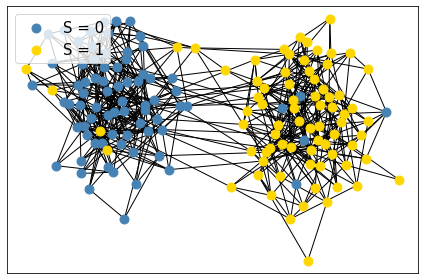

In [4]:
# Visualisation of the generated graph 

#Retrieve indexes of node in each group
s_idx = np.fromiter(s.values(), dtype=int)
prot0 = np.where(s_idx == 0)[0]
prot1 = np.where(s_idx == 1)[0]

# Draw the graph 
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos=pos, node_size=80, nodelist=prot0, node_color='steelblue', label='S = 0')
nx.draw_networkx_nodes(g, pos=pos, node_size=80, nodelist=prot1, node_color='gold', label='S = 1')
nx.draw_networkx_edges(g, pos=pos)
plt.legend(loc="upper left", scatterpoints=1, prop={'size': 15})
plt.tight_layout()
plt.show()

## a) Repairing with OT (EMD version)

In [5]:
print("Correcting the graph with EMD")

emd_adj, s_emd, gamma, M = total_repair_emd(g,  metric='euclidean', log=False)
# Build corrected graph from the corrected adjacency matrix
emd_g = nx.from_numpy_matrix(emd_adj)

# Filter out the smallest weights to keep a reasonable density
list_edge = [(u, v) for (u, v, d) in emd_g.edges(data=True) if d['weight'] < 0.5]
emd_g.remove_edges_from (list_edge)

# Coefficient of assortativity on the repaired graph
dict_s = {i: s_emd[i] for i in range(0, len(s_emd))}
nx.set_node_attributes(emd_g, dict_s, 's')
print('Assortativity coeffcient on the repaired (EMD) graph: %0.3f'
      % nx.attribute_assortativity_coefficient(emd_g, 's'))

Correcting the graph with EMD
Assortativity coeffcient on the repaired (EMD) graph: -0.217


### Impact on the embeddings

We are now ready to illustrate the impact of the repairing on the node embeddings. 
To proceed, we use Node2Vec as an example.

In [6]:
# 조금오래걸리는편(<1분)
# Learn node embeddings for both graphs
print("Start learning embedding on the original graph")
embedding_origin, s_origin, modelO = emb_node2vec(g, s_idx)

print("Start learning embedding on the repaired graph")
embedding_emd, s_emd, modelR = emb_node2vec(emd_g, s_idx)

Start learning embedding on the original graph


Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████| 100/100 [00:10<00:00,  9.17it/s]


Start learning embedding on the repaired graph


Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████| 100/100 [00:12<00:00,  8.17it/s]


## b) Correction of the graph with the laplacian regularizer

In [7]:
# 조금걸림(<3분)
print("Correcting the graph with Laplacian regularizer")

r = 0.01
new_x_l, s, gamma, M = total_repair_reg(g, metric='euclidean', reg=r)
lap_g = nx.from_numpy_matrix(new_x_l)

# Filter out the smallest weights to keep a reasonable density
list_edge = [(u, v) for (u, v, d) in lap_g.edges(data=True) if d['weight'] < 0.5]
lap_g.remove_edges_from(list_edge)

Correcting the graph with Laplacian regularizer
It.  |Err         
-------------------
 1000|4.801334e-04|
It.  |Err         
-------------------
 2000|2.565690e-04|
It.  |Err         
-------------------
 3000|1.796384e-04|
It.  |Err         
-------------------
 4000|1.392463e-04|
It.  |Err         
-------------------
 5000|1.106160e-04|


In [8]:
# Coefficient of assortativity
dict_s = {i: s[i] for i in range(0, len(s))}
nx.set_node_attributes(lap_g, dict_s, 's')
print('Assortativity coefficient on the repaired (Lap) graph: %0.3f'
      % nx.attribute_assortativity_coefficient(lap_g, 's'))  

Assortativity coefficient on the repaired (Lap) graph: 0.386


In [9]:
# 조금 걸리는편 (<1분)
# Compute the embeddings
embedding_lap, s_lap, modelR = emb_node2vec(lap_g, s_idx)

Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████| 100/100 [00:08<00:00, 11.21it/s]


# Compare RB metric

In [10]:
# Compute the Representation Bias
clf = model_selection.KFold(n_splits=5, random_state=100, shuffle=True)
clf = LogisticRegression(solver='lbfgs')

kfold = 5

results_lap = model_selection.cross_val_score(clf, embedding_lap, s_lap, cv=kfold,
                                                     scoring='roc_auc')

results_emd = model_selection.cross_val_score(clf, embedding_emd, s_emd, cv=kfold,
                                                     scoring='roc_auc')

results_origin = model_selection.cross_val_score(clf, embedding_origin, s_origin, cv=kfold,
                                                     scoring='roc_auc')

print("RB on the repaired graph (Laplace version) is: %8.2f" % results_lap.mean())
print("RB on the repaired graph (EMD) is: %8.2f" % results_emd.mean())
print("RB on the original graph is: %8.2f" % results_origin.mean())

RB on the repaired graph (Laplace version) is:     0.91
RB on the repaired graph (EMD) is:     0.67
RB on the original graph is:     0.89


# Visualization

In [11]:
# generate embeddings with TSNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

names = ['Original', 'EMD', 'Laplacian']
embs = [s_origin, s_emd, s_lap]

data_tsne = []
data_tsne.append(tsne.fit_transform(embedding_origin))
data_tsne.append(tsne.fit_transform(embedding_emd))
data_tsne.append(tsne.fit_transform(embedding_lap))

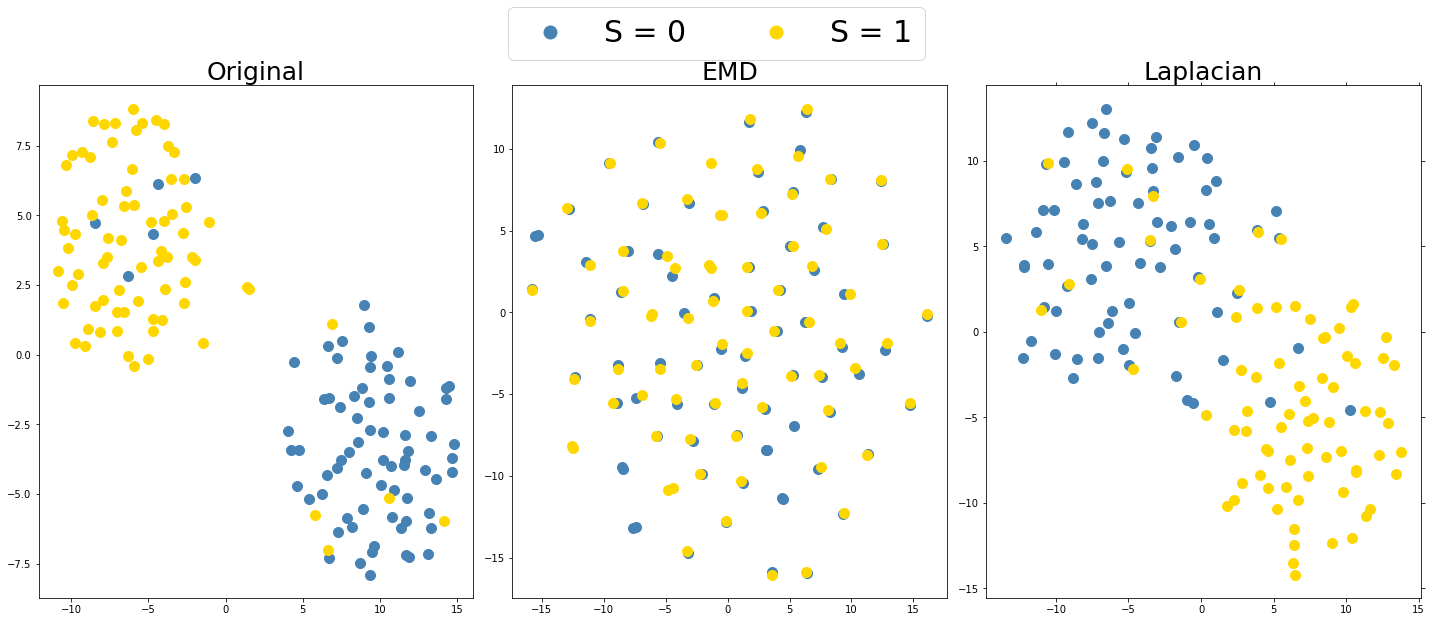

In [18]:
# visualization
c = ['steelblue', 'gold']
legend_elements = [Line2D([0], [0], marker='o', color='white', label='S = 0', markerfacecolor='steelblue', markersize=15),
        Line2D([0], [0], marker='o', color='white', label='S = 1',  markerfacecolor='gold', markersize=15),
      ]

fig, axes = plt.subplots(1, len(data_tsne), figsize=(20, 8))

# plotting
for ax, d, emb, name in zip(axes, data_tsne, embs, names):
    x, y = d[:, 0], d[:, 1]
    for k, l in enumerate(np.unique(emb)):
        i = np.where(emb == l)
        ax.scatter(x[i], y[i], color=c[k], s=100)
        ax.set_title(name, fontsize=25)

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.1), 
                  ncol=3, fancybox=True, shadow=False, prop={'size': 30}, fontsize=30)
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', 
                         labelleft='off')
plt.tight_layout()
plt.show()

# Link Prediction(TBD)